In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import xgboost as xgb
from sklearn.metrics import mean_squared_error

import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [29]:


df_all = None
df_last = None
df_first = None
file_list = os.listdir('./data')
for file in file_list:
    df = pd.read_csv(f'./data/{file}', encoding='euc-kr')
    print(df.columns)
    stage = file.split('_')[0]
    print(stage)
    for i in range(1, 57):
        df_last = df[['시간', f'ch{i} 전압', f'ch{i} 전류', f'ch{i} 용량', f'ch{i} PV']]
        df_last = df_last.rename(columns={'시간':'ds', f'ch{i} 전압': 'vol', f'ch{i} 전류': 'curr', f'ch{i} 용량': 'q_val',  f'ch{i} PV': 'pv'})
        df_last.drop(['pv'], axis=1, inplace=True)
        df_last.fillna(0, inplace=True)

    if df_first is None:
        df_first = df_last
    # print(file)


Index(['시간', 'ch1 전압', 'ch1 전류', 'ch1 용량', 'ch1 PV', 'ch2 전압', 'ch2 전류',
       'ch2 용량', 'ch2 PV', 'ch3 전압',
       ...
       '온도3', '온도4', '온도5', '온도6', '온도7', '온도8', '온도9', '온도10', '온도11',
       '온도12'],
      dtype='object', length=237)
T01730
Index(['시간', 'ch1 전압', 'ch1 전류', 'ch1 용량', 'ch1 PV', 'ch2 전압', 'ch2 전류',
       'ch2 용량', 'ch2 PV', 'ch3 전압',
       ...
       '온도3', '온도4', '온도5', '온도6', '온도7', '온도8', '온도9', '온도10', '온도11',
       '온도12'],
      dtype='object', length=237)
T75979
Index(['시간', 'ch1 전압', 'ch1 전류', 'ch1 용량', 'ch1 PV', 'ch2 전압', 'ch2 전류',
       'ch2 용량', 'ch2 PV', 'ch3 전압',
       ...
       '온도3', '온도4', '온도5', '온도6', '온도7', '온도8', '온도9', '온도10', '온도11',
       '온도12'],
      dtype='object', length=237)
T40483
Index(['시간', 'ch1 전압', 'ch1 전류', 'ch1 용량', 'ch1 PV', 'ch2 전압', 'ch2 전류',
       'ch2 용량', 'ch2 PV', 'ch3 전압',
       ...
       '온도3', '온도4', '온도5', '온도6', '온도7', '온도8', '온도9', '온도10', '온도11',
       '온도12'],
      dtype='object', length=237)
T71411


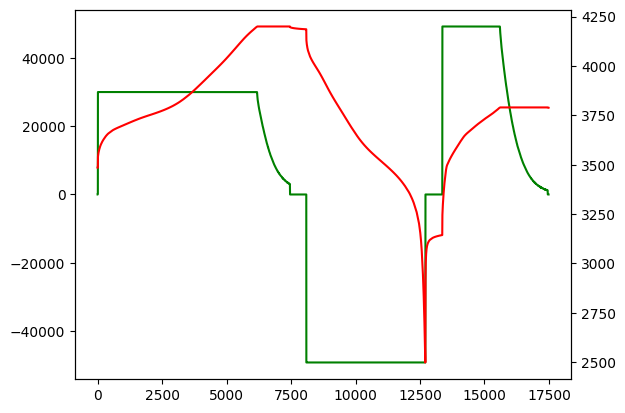

In [30]:
fig, ax1 = plt.subplots()

ax1.plot(df_last['curr'], 'g')
ax2 = ax1.twinx()
ax2.plot(df_last['vol'], 'r')

In [31]:
df_last

,ds,vol,curr,q_val
0,0000:00:00,3485.1,0,0
1,0000:00:01,3485.1,0,0
2,0000:00:02,3485.1,0,0
3,0000:00:03,3485.1,0,0
4,0000:00:04,3485.1,248,0
...,...,...,...,...
17480,0004:51:20,3788.9,0,37635
17481,0004:51:21,3788.9,0,37635
17482,0004:51:22,3788.8,0,37635
17483,0004:51:23,3788.8,0,37635


First of all, I'll create features for time-series.  
Using 'ds', Hour, Min, Second can be extracted and I'll add 'Series' as a additive feature.

In [58]:
def add_features(df):
    df['hour'] = df['ds'].apply(lambda x: int(x.split(':')[0]))
    df['min'] = df['ds'].apply(lambda x: int(x.split(':')[1]))
    df['series'] = np.arange(1, len(df) + 1)
    # q_diff는 필요하지 않아보임. 현재까지의 누적량이 영향을 미침.
    # df['q_diff'] = df['q_val'] - df['q_val'].shift(1)
    df.drop(['ds'], axis=1, inplace=True)
    return df

In [33]:
df_train = add_features(df_first)
df_test= add_features(df_last)

In [35]:
FEATURES = ['curr', 'q_val', 'hour', 'min', 'series']
TARGET = 'vol'

In [42]:
X_train = df_train[FEATURES]
y_train = df_train[TARGET]
X_test = df_test[FEATURES]
y_test = df_test[TARGET]

In [43]:

reg = xgb.XGBRegressor(booster='gbtree', n_estimators=1000)
reg.fit(X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100)

[0]	validation_0-rmse:2643.44658	validation_1-rmse:2647.11695
[100]	validation_0-rmse:1.09106	validation_1-rmse:32.62545
[200]	validation_0-rmse:0.56597	validation_1-rmse:32.75122
[300]	validation_0-rmse:0.37420	validation_1-rmse:32.75497
[400]	validation_0-rmse:0.28851	validation_1-rmse:32.76274
[500]	validation_0-rmse:0.23108	validation_1-rmse:32.76965
[600]	validation_0-rmse:0.18735	validation_1-rmse:32.76967
[700]	validation_0-rmse:0.15874	validation_1-rmse:32.76936
[800]	validation_0-rmse:0.13828	validation_1-rmse:32.76987
[900]	validation_0-rmse:0.12245	validation_1-rmse:32.77034
[999]	validation_0-rmse:0.11068	validation_1-rmse:32.77064


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

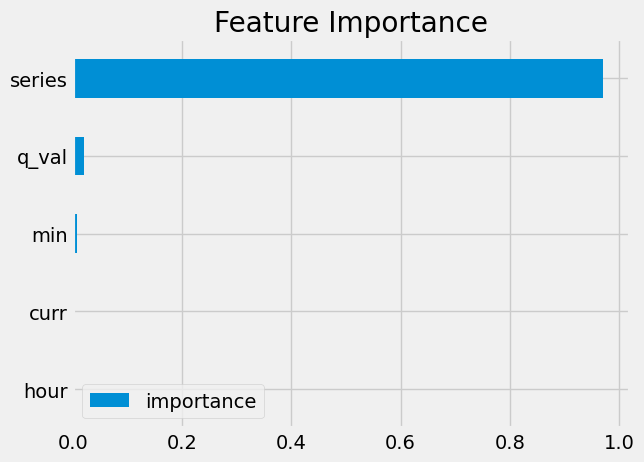

In [56]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [105]:
df_all = None
df_last = None
df_first = None
df_list = []
file_list = os.listdir('./data')
for file in file_list:
    df = pd.read_csv(f'./data/{file}', encoding='euc-kr')
    stage = file.split('_')[0]
    for i in range(1, 57):
        # _sc => stage_channel
        df_sc = df[['시간', f'ch{i} 전압', f'ch{i} 전류', f'ch{i} 용량', f'ch{i} PV']]
        df_sc = df_sc.rename(columns={'시간':'ds', f'ch{i} 전압': 'vol', f'ch{i} 전류': 'curr', f'ch{i} 용량': 'q_val',  f'ch{i} PV': 'pv'})
        df_sc.drop(['pv'], axis=1, inplace=True)
        df_sc = add_features(df_sc)
        df_list.append({'stage': stage, 'ch': i, 'data': df_sc})
    print(f'Stage : {stage} loaded.')


Stage : T01730 loaded.
Stage : T75979 loaded.
Stage : T40483 loaded.
Stage : T71411 loaded.


In [106]:
df_list[0]['data']

,vol,curr,q_val,hour,min,series
0,3481.7,0,0,0,0,1
1,3481.7,0,0,0,0,2
2,3481.8,0,0,0,0,3
3,3482.0,0,0,0,0,4
4,3482.5,250,0,0,0,5
...,...,...,...,...,...,...
17530,3788.2,0,37630,4,52,17531
17531,3788.2,0,37630,4,52,17532
17532,3788.2,0,37630,4,52,17533
17533,3788.2,0,37630,4,52,17534


In [108]:
test = []
score = []
for df in df_list:
    pred = reg.predict(df['data'][FEATURES])
    test.append(pred)
    sc = np.sqrt(mean_squared_error(df['data'][TARGET], pred ))
    print(sc)
    score.append(sc)


24.176069449746798
6.636265875661593
6.617652224626998
6.142099845360328
9.04690823025969
11.464713190149157
7.931678640034868
2.283572707473842
14.021044801148644
4.704336312713116
4.4962463216975985
12.8563118174957
13.813741899244578
12.339187932603583
7.747300034352693
6.1772795724264995
5.824965596355186
8.967651297915292
8.243308391251306
5.173871823844292
5.545815623197757
6.249443913736859
6.543876625198144
6.608066117156206
15.179610555039451
14.858339917481784
12.746976887191488
6.4637785658466775
26.759935130768504
11.807758138662182
25.943197519330326
19.097981291196618
16.61198083110342
19.40893365767702
28.58893976097164
16.11626182805696
26.080477368804786
21.459411103464877
15.84617302351456
15.29943648864
16.324456622723748
15.89457309626353
22.309785626616446
20.557901554117535
26.493391540768265
24.71287951593767
26.746122485107772
22.64689671043214
23.207571024824457
17.735604390759878
29.63266845235955
20.24336153566857
26.195839987749054
30.838039876628063
17.5505

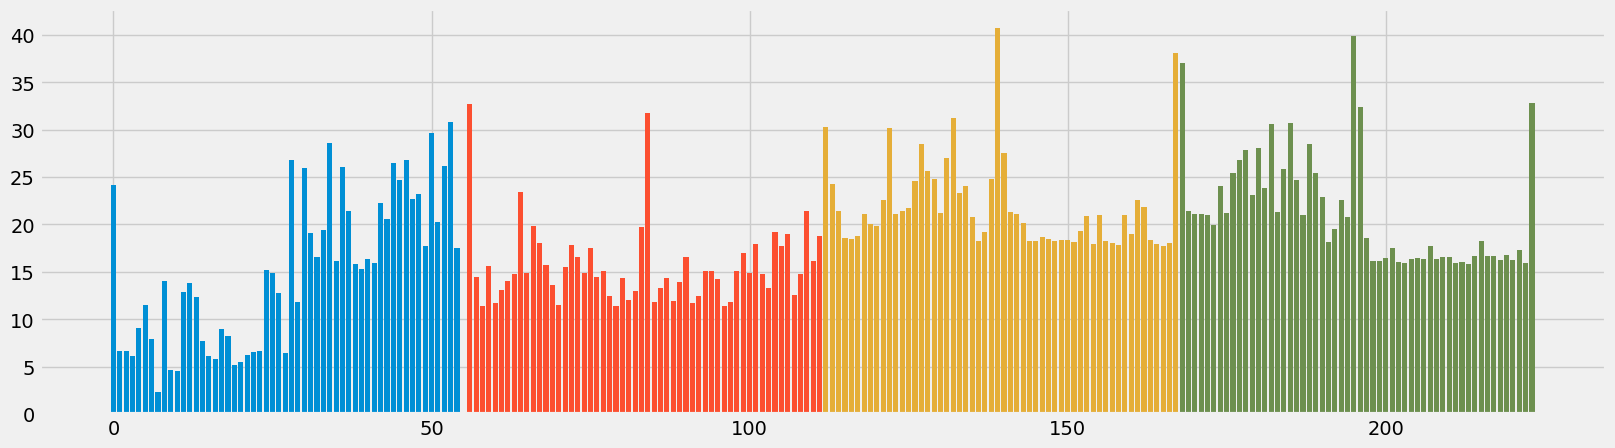

In [111]:
plt.figure(figsize=(18,5))
for i in range(4):
    plt.bar(np.arange(i*56, (i+1)*56), score[i*56:(i+1)*56])
